## Facebook Ego Network<br>A Graph Analysis

_Ego network analysis focuses on a central individual—referred to as the ego—and explores the structure and features of their immediate social connections, or alters. In the context of Facebook, ego networks capture the friendship relations of a user and how their friends are connected among themselves._

Imports

In [22]:
!pip install python-louvain

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from networkx.algorithms.community import greedy_modularity_communities
import networkx as nx
from collections import Counter
from community import community_louvain
from sklearn.cluster import SpectralClustering

Load / Prepare Data

_The Facebook Ego Network dataset provides a structured view of a user's local social environment through multiple file types. Each ego user has an .edges file, listing pairs of friend connections that form the social graph around the ego (excluding the ego themselves). The .feat file contains binary feature vectors for each of the ego's friends, representing attributes like education, location, or employment in a one-hot encoded format. The .egofeat file holds the ego's own feature vector, allowing comparison with their friends. Optional .circles files include user-defined friend groups, where each line represents a circle containing friend IDs. Finally, the .featnames file maps each feature index to a descriptive label, enabling meaningful interpretation of the feature data. Together, these files support rich analysis of both structural and attribute-based aspects of ego networks._

In [24]:
# Set folder path
data_folder = "facebook"

# Discover ego user IDs
file_list = os.listdir(data_folder)
ego_ids = set(fname.split('.')[0] for fname in file_list if fname.endswith('.edges'))

# Load all data into dictionaries
edges_dict = {}
feat_dict = {}
egofeat_dict = {}
circles_dict = {}

for ego_id in ego_ids:
    try:
        edges = pd.read_csv(f"{data_folder}/{ego_id}.edges", sep=" ", header=None, names=["From", "To"])
        edges_dict[ego_id] = edges

        feat = pd.read_csv(f"{data_folder}/{ego_id}.feat", sep=" ", header=None)
        feat.index = feat.index.astype(int)
        feat_dict[ego_id] = feat

        egofeat = pd.read_csv(f"{data_folder}/{ego_id}.egofeat", sep=" ", header=None)
        egofeat_dict[ego_id] = egofeat

        circles_path = f"{data_folder}/{ego_id}.circles"
        if os.path.exists(circles_path):
            with open(circles_path, "r") as f:
                circles = [line.strip().split("\t") for line in f]
            circles_dict[ego_id] = circles
        else:
            circles_dict[ego_id] = []
    except Exception as e:
        print(f"Error loading ego {ego_id}: {e}")

# Load feature names once

ego_id = "107"  # Replace "0" with the ego ID you want to use
sample_id = ego_id
# Or comment out the line above to use the first ID automatically
if 'ego_id' not in locals():
    sample_id = next(iter(ego_ids))  # fallback automatic
    ego_id = sample_id

print(f"Using ego network with ID: {ego_id}")

with open(f"{data_folder}/{sample_id}.featnames", "r") as f:
    featnames = [line.strip() for line in f]

Using ego network with ID: 107


Build Graph, add features and links to friends

In [25]:
# Build one ego graph 
ego_id = sample_id
friend_ids = feat_dict[ego_id].index.tolist()
G = nx.from_pandas_edgelist(edges_dict[ego_id], source="From", target="To")

# Add features to friends
for i, node_id in enumerate(friend_ids):
    G.add_node(node_id)
    G.nodes[node_id]['features'] = feat_dict[ego_id].iloc[i].tolist()

# Add ego node
ego_node = int(ego_id)
G.add_node(ego_node)
G.nodes[ego_node]['features'] = egofeat_dict[ego_id].iloc[0].tolist()

# Connect ego to all friends
for friend in friend_ids:
    G.add_edge(ego_node, friend)

print(f"Graph for ego {ego_id}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

Graph for ego 107: 1903 nodes, 27794 edges.


Find bridge nodes and Degree Distribution

Bridge nodes: [1240, 1909, 904, 107, 1739, 1660, 1797, 1202, 596, 1791, 1860, 1711, 1591, 1347, 1536, 1194, 1492, 1835]

--- Structural Analysis ---
Nodes: 1903
Edges: 27794
Connected Components: 1
Average Clustering Coefficient: 0.2823328600458572


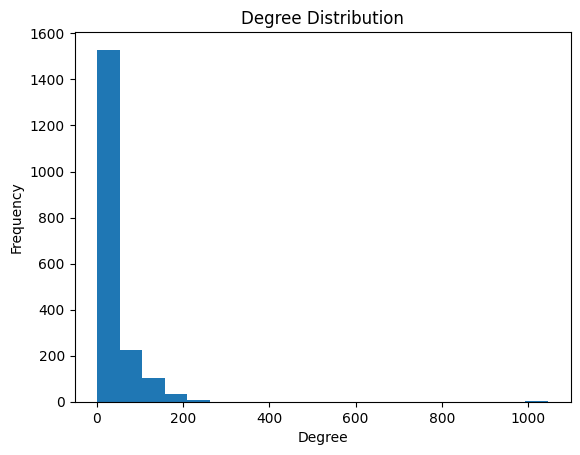

In [26]:
bridge_nodes = list(nx.articulation_points(G))
print("Bridge nodes:", bridge_nodes)

# Structural analysis
print("\n--- Structural Analysis ---")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())
print("Connected Components:", nx.number_connected_components(G))
print("Average Clustering Coefficient:", nx.average_clustering(G))

degrees = [d for _, d in G.degree()]
plt.hist(degrees, bins=20)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

_The structural analysis of the Facebook ego network reveals a graph composed of 1,903 nodes and 27,794 edges, forming a single connected component. This indicates that every user in the network is reachable from any other, directly or indirectly, highlighting a high level of overall connectivity. The average clustering coefficient is approximately 0.28, suggesting a moderate tendency of friends to form tightly knit groups where mutual connections are common. A set of specific nodes—such as 1240, 1909, 904, and others—have been identified as bridge nodes. These nodes likely serve as critical connectors between different regions or communities within the network, playing an important role in maintaining cohesion and enabling information flow across otherwise separate subgroups._

Centrality metrics

In [27]:
print("\n--- Centrality Measures ---")
deg_cent = nx.degree_centrality(G)
bet_cent = nx.betweenness_centrality(G)
clo_cent = nx.closeness_centrality(G)
eig_cent = nx.eigenvector_centrality(G, max_iter=1000)

top_deg = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by Degree Centrality:")
for node, score in top_deg:
    print(f"Node {node}: {score:.4f}")

top_bet = sorted(bet_cent.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by Betweenness Centrality:")
for node, score in top_bet:
    print(f"Node {node}: {score:.4f}")

top_clo = sorted(clo_cent.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by Closeness Centrality:")
for node, score in top_clo:
    print(f"Node {node}: {score:.4f}")

top_eig = sorted(eig_cent.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by Eigenvector Centrality:")
for node, score in top_eig:
    print(f"Node {node}: {score:.4f}")


--- Centrality Measures ---
Top 5 nodes by Degree Centrality:
Node 107: 0.5499
Node 1888: 0.1330
Node 1800: 0.1283
Node 1663: 0.1230
Node 1352: 0.1225
Top 5 nodes by Betweenness Centrality:
Node 107: 0.7662
Node 1086: 0.0227
Node 483: 0.0196
Node 917: 0.0195
Node 925: 0.0109
Top 5 nodes by Closeness Centrality:
Node 107: 0.6718
Node 483: 0.4778
Node 917: 0.4753
Node 637: 0.4718
Node 606: 0.4692
Top 5 nodes by Eigenvector Centrality:
Node 1888: 0.1166
Node 1800: 0.1123
Node 1663: 0.1095
Node 1352: 0.1085
Node 1431: 0.1048


_The centrality analysis highlights the most influential nodes in the ego network based on various measures. Node 107, the ego, ranks highest across all major centrality metrics, indicating its dominant role in the network's structure. With a degree centrality of 0.5499, it has direct connections to over half the nodes, confirming its central position. It also exhibits a betweenness centrality of 0.7662, far exceeding all others, suggesting that it frequently lies on the shortest paths between other nodes and acts as a key intermediary. In terms of closeness centrality, Node 107 again leads, reflecting its ability to reach all other nodes with minimal steps. Interestingly, while Node 107 dominates structural centrality, nodes like 1888, 1800, and 1663 score highest in eigenvector centrality, implying that they are well-connected to other influential nodes. These patterns collectively provide insight into how central figures and influential subgroups shape the connectivity and information flow within the network._

Ego Graph

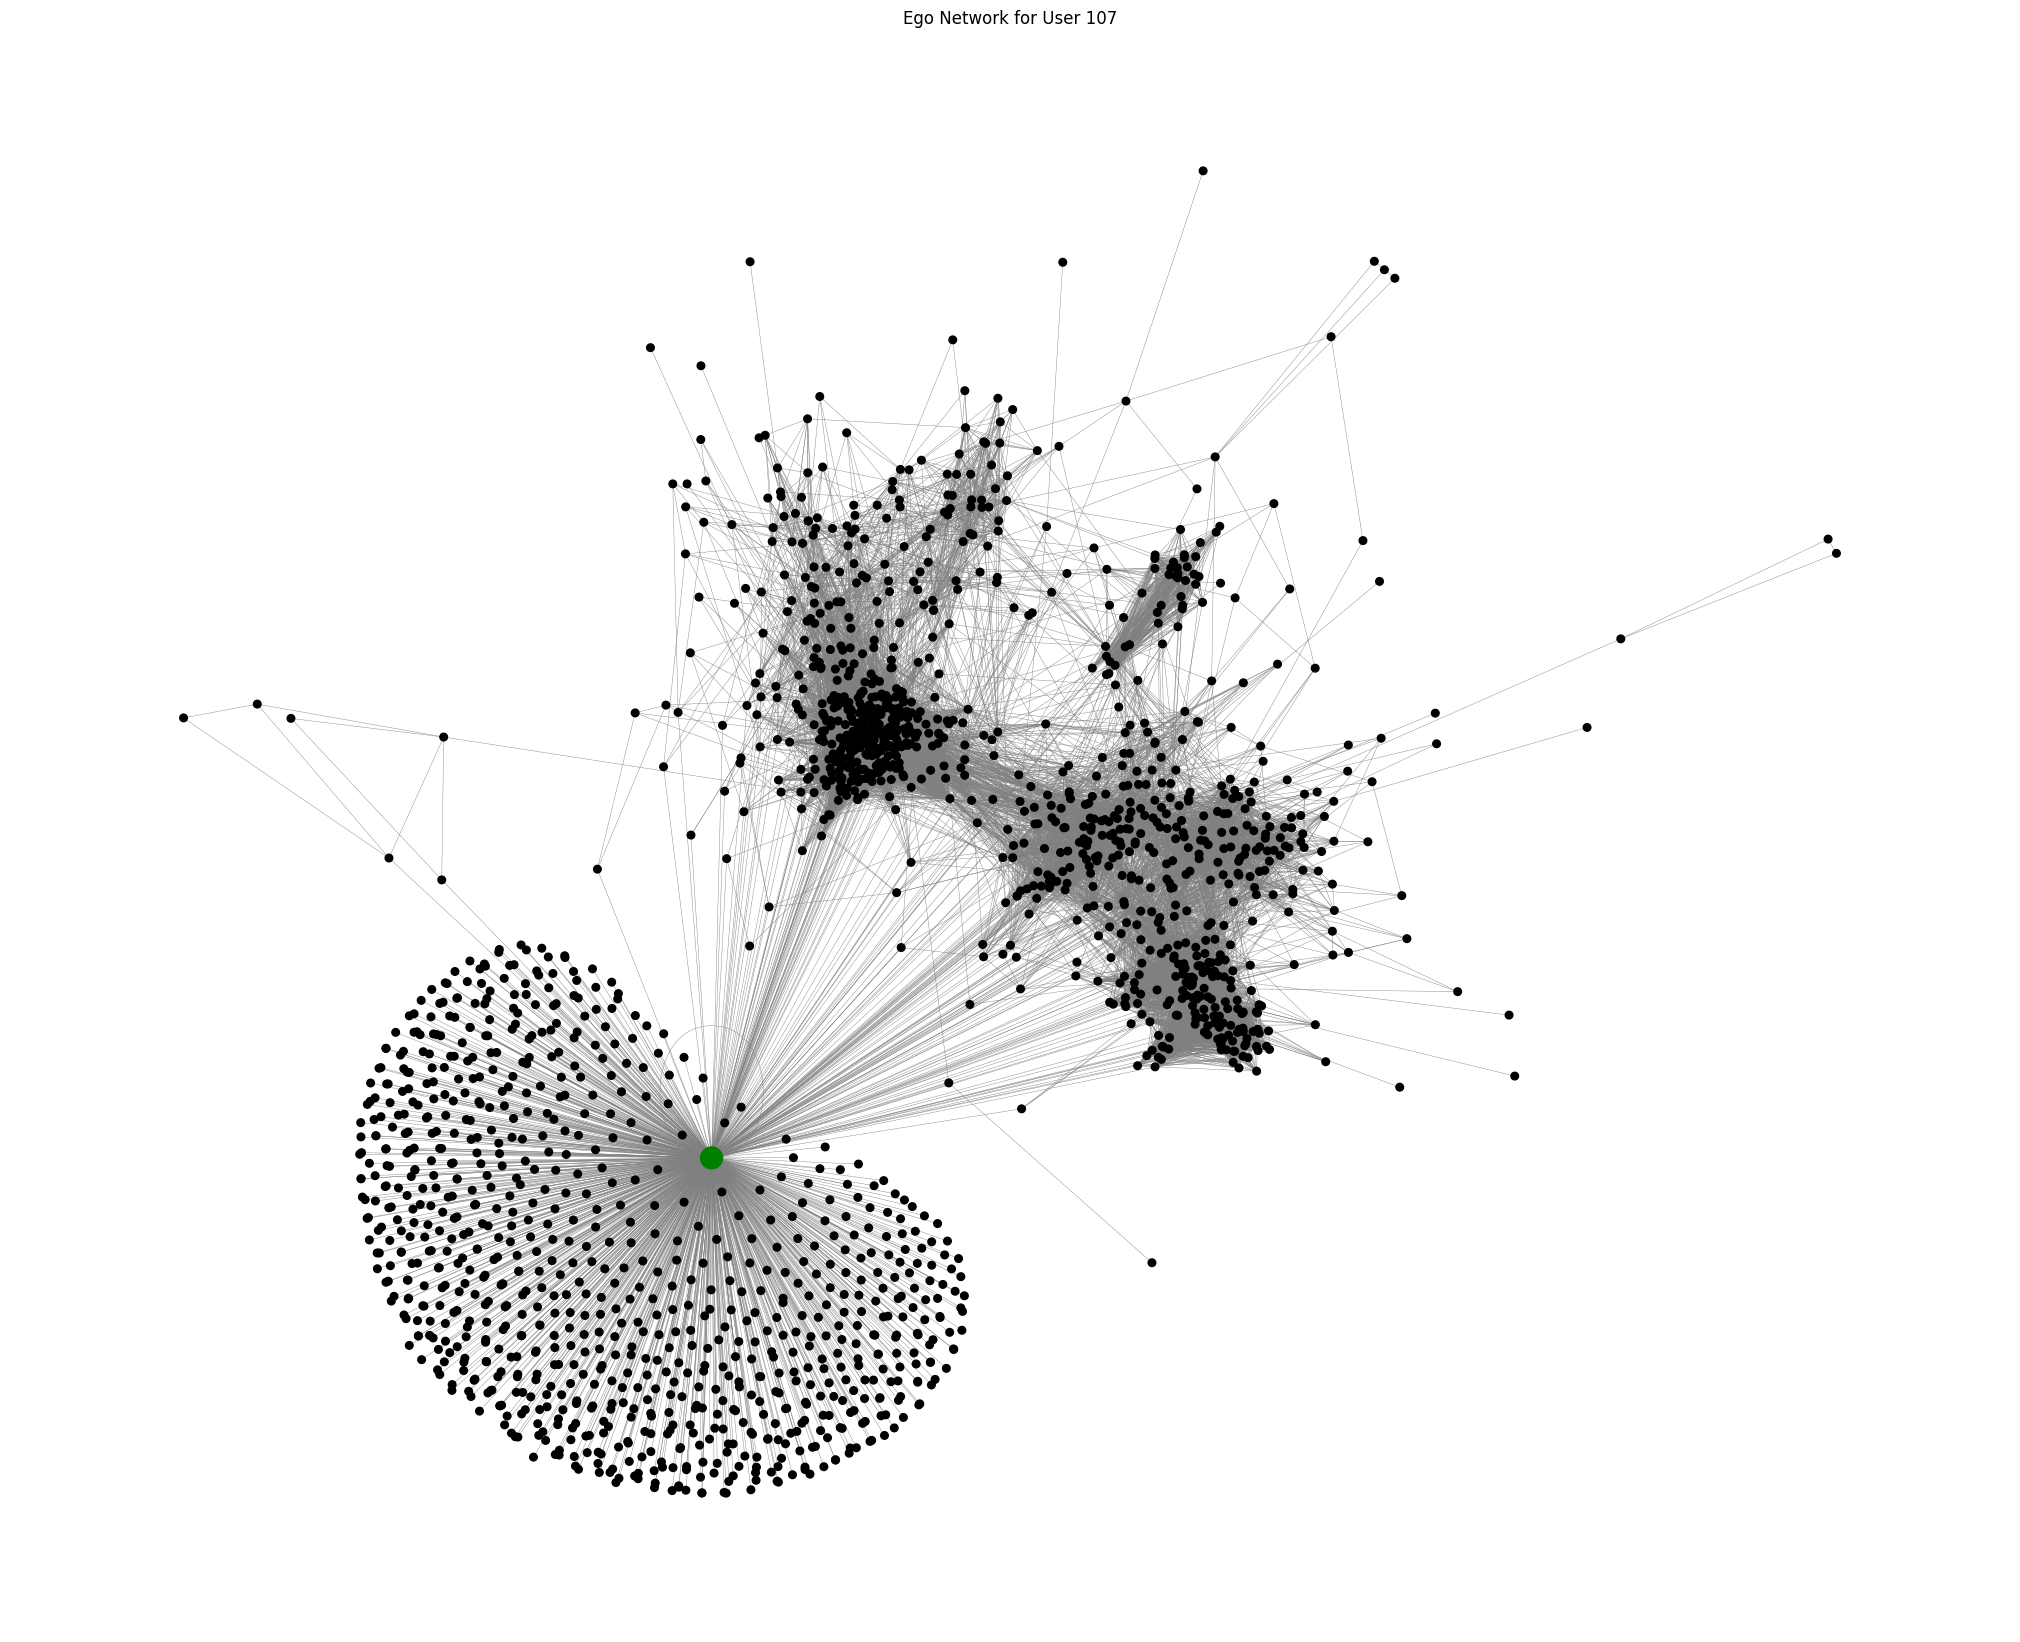

Graph image saved as ego_graph_107.png


In [28]:
plt.figure(figsize=(20, 16))
node_colors = ['green' if node == ego_node else 'black' for node in G.nodes()]
node_sizes = [250 if node == ego_node else 30 for node in G.nodes()]
nx.draw(G, node_size=node_sizes, node_color=node_colors, # Already defined earlier
    edge_color='gray',      # Softer edges
    width=0.3,              # Thinner lines
    with_labels=False)
plt.title(f"Ego Network for User {ego_id}")
plt.savefig(f"ego_graph_{ego_id}.png", dpi=300)
plt.show()
plt.close()

print(f"Graph image saved as ego_graph_{ego_id}.png")

_This network visualization of the ego graph for user 107 reveals two contrasting structural regions. The ego node, shown in green at the center, connects to two distinct parts of the network. On the left side, we see a sparse and radial structure where the ego's friends are largely unconnected to one another. This pattern suggests a set of acquaintances or loosely related individuals who rely solely on the ego for connection, with little to no interaction among themselves. In contrast, the right side of the graph displays a densely interconnected structure, where the ego's friends form multiple overlapping clusters with many internal connections. This indicates cohesive social groups, such as tightly knit communities or circles where members know and interact with each other independently of the ego. The visualization highlights the ego’s bridging role between disconnected individuals and organized communities within the social network._

Feature Similarity Graph construsting and plot


--- Building Shared Feature Similarity Graph (≥15% match) ---
Constructed similarity graph with 1046 nodes and 610 edges.


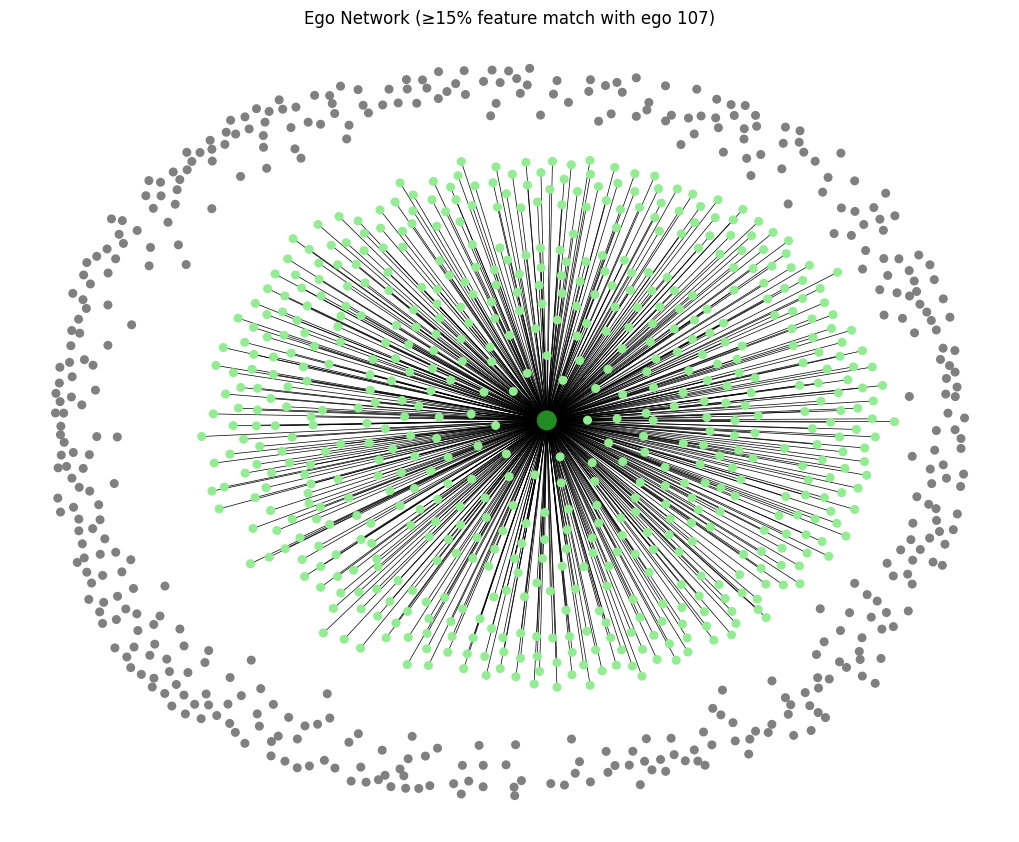

In [29]:
print("\n--- Building Shared Feature Similarity Graph (≥15% match) ---")

# Get ego features (binary vector)
ego_feat = egofeat_dict[ego_id].iloc[0].values
ego_feat_indices = np.where(ego_feat == 1)[0]  # Indices where ego has feature "on"

# If ego has no active features, skip
if len(ego_feat_indices) == 0:
    print("Ego has no active features. Skipping similarity-based graph.")
else:
    G_sim = nx.Graph()
    G_sim.add_node(ego_id, color='green')

    for friend_id in feat_dict[ego_id].index:
        friend_feat = feat_dict[ego_id].loc[friend_id].values
        overlap = friend_feat[ego_feat_indices].sum()
        match_ratio = overlap / len(ego_feat_indices)

        G_sim.add_node(friend_id, color='blue')
        if match_ratio > 0.15:
            G_sim.add_edge(ego_id, friend_id, weight=match_ratio)

    print(f"Constructed similarity graph with {G_sim.number_of_nodes()} nodes and {G_sim.number_of_edges()} edges.")
    
    colors = []
    for node in G_sim.nodes():
        if node == ego_id:
            colors.append("forestgreen")
        elif G_sim.has_edge(ego_id, node):
            colors.append("lightgreen")
        else:
            colors.append("grey")

    sizes = [180 if node == ego_id else 30 for node in G_sim.nodes()]
    pos = nx.spring_layout(G_sim, seed=42, k=0.15)

    # Draw graph
    plt.figure(figsize=(10, 8))
    nx.draw(G_sim, pos, node_color=colors, node_size=sizes, with_labels=False, edge_color="black", width=0.5)
    plt.title(f"Ego Network (≥15% feature match with ego {ego_id})")
    plt.show()
    plt.close()


**Communities and Intuitions**

Greedy modularity communities

In [30]:
print("\n--- Community Detection ---")
communities = list(greedy_modularity_communities(G))
print(f"Detected {len(communities)} communities.")
print("Community sizes:", [len(c) for c in communities])


print("\n--- Analyzing Most Common Anonymized Feature Values in Largest Community ---")

# Step 1: Largest community
largest_community = max(communities, key=len)
print(f"Largest community size: {len(largest_community)}")

expected_length = len(featnames)
valid_vectors = []

for node in largest_community:
    features = G.nodes[node].get('features')
    if features is not None:
        if len(features) < expected_length:
            # Fill with zeros if feature vector is too short
            padded = features + [0] * (expected_length - len(features))
            valid_vectors.append(padded)
        else:
            valid_vectors.append(features[:expected_length])


# Convert to NumPy array
feature_matrix = np.array(valid_vectors)

# Convert all non-zero values to 1 (binary presence)
binary_matrix = (feature_matrix != 0).astype(int)

# Sum presence across all users
feature_counts = binary_matrix.sum(axis=0)

# Step 4: Get top features
top_features = sorted(enumerate(feature_counts), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 most common anonymized features in the largest community:")
for idx, count in top_features:
    print(f"{idx}: {featnames[idx]} (count: {int(count)})")



--- Community Detection ---
Detected 8 communities.
Community sizes: [1422, 392, 56, 20, 5, 3, 3, 2]

--- Analyzing Most Common Anonymized Feature Values in Largest Community ---
Largest community size: 1422

Top 10 most common anonymized features in the largest community:
0: 0 birthday;anonymized feature 376 (count: 981)
221: 221 education;type;anonymized feature 54 (count: 775)
223: 223 education;with;id;anonymized feature 539 (count: 695)
349: 349 locale;anonymized feature 278 (count: 686)
266: 266 hometown;id;anonymized feature 558 (count: 629)
265: 265 gender;anonymized feature 78 (count: 341)
220: 220 education;type;anonymized feature 53 (count: 322)
222: 222 education;type;anonymized feature 55 (count: 314)
350: 350 location;id;anonymized feature 128 (count: 266)
274: 274 hometown;id;anonymized feature 563 (count: 244)


_Community detection using the greedy modularity algorithm revealed a total of eight distinct communities within the ego network of user 107, with the largest community comprising 1,422 nodes. This dominant group reflects a highly cohesive cluster of individuals who are densely interconnected, as also suggested by the network visualization. An analysis of the most frequent anonymized features within this community provides insight into common attributes shared by its members._

LOUVAIN community detection (undirected) and related metrics

In [31]:
excluded_keywords = {"birthday"}

print("\n--- Community Detection ---")

# Step 1: Run Louvain and gather communities
partition = community_louvain.best_partition(G)
communities_dict = {}
for node, comm_id in partition.items():
    communities_dict.setdefault(comm_id, set()).add(node)

# Step 2: Print total number of communities and their sizes
community_sizes = [len(nodes) for nodes in communities_dict.values()]
sorted_sizes = sorted(community_sizes, reverse=True)

print(f"Detected {len(community_sizes)} communities.")
print(f"Community sizes: {sorted_sizes}")

# Step 3: Find the largest community
largest_comm_id, largest_nodes = max(communities_dict.items(), key=lambda x: len(x[1]))
largest_nodes = list(largest_nodes)

# Step 4: Gather feature matrix for the largest community
vectors = []
for node in largest_nodes:
    feats = G.nodes[node].get("features")
    if feats:
        vectors.append(feats)

if not vectors:
    print("\nNo feature data found in the largest community.")
else:
    expected_len = len(featnames)
    padded_vectors = []

    for v in vectors:
        if len(v) < expected_len:
            v = v + [0] * (expected_len - len(v))
        elif len(v) > expected_len:
            v = v[:expected_len]
        padded_vectors.append(v)

    feature_matrix = np.array(padded_vectors)
    binary_matrix = (feature_matrix != 0).astype(int)
    feature_counts = binary_matrix.sum(axis=0)

    # Step 5: Print top 10 most common anonymized features
    sorted_features = sorted(enumerate(feature_counts), key=lambda x: x[1], reverse=True)

    print(f"\n--- Analyzing Most Common Anonymized Feature Values in Largest Community ---")
    print(f"Largest community size: {len(largest_nodes)}\n")

    print("Top 10 most common anonymized features in the largest community:")
    top_k = 10
    count = 0
    for idx, freq in sorted_features:
        if idx >= len(featnames):
            continue
        fname = featnames[idx]
        print(f"{idx}: {idx} {fname} (count: {int(freq)})")
        count += 1
        if count == top_k:
            break



--- Community Detection ---
Detected 7 communities.
Community sizes: [881, 324, 185, 170, 155, 150, 38]

--- Analyzing Most Common Anonymized Feature Values in Largest Community ---
Largest community size: 881

Top 10 most common anonymized features in the largest community:
0: 0 0 birthday;anonymized feature 376 (count: 873)
221: 221 221 education;type;anonymized feature 54 (count: 685)
223: 223 223 education;with;id;anonymized feature 539 (count: 611)
349: 349 349 locale;anonymized feature 278 (count: 606)
266: 266 266 hometown;id;anonymized feature 558 (count: 565)
265: 265 265 gender;anonymized feature 78 (count: 298)
220: 220 220 education;type;anonymized feature 53 (count: 290)
222: 222 222 education;type;anonymized feature 55 (count: 279)
350: 350 350 location;id;anonymized feature 128 (count: 242)
274: 274 274 hometown;id;anonymized feature 563 (count: 214)


Plot the Ego Network Graph again, using Luvain Communities

/var/folders/3j/h47tr53n7d9bgx_2tmz3q58w0000gn/T/ipykernel_55365/4039751973.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(communities))


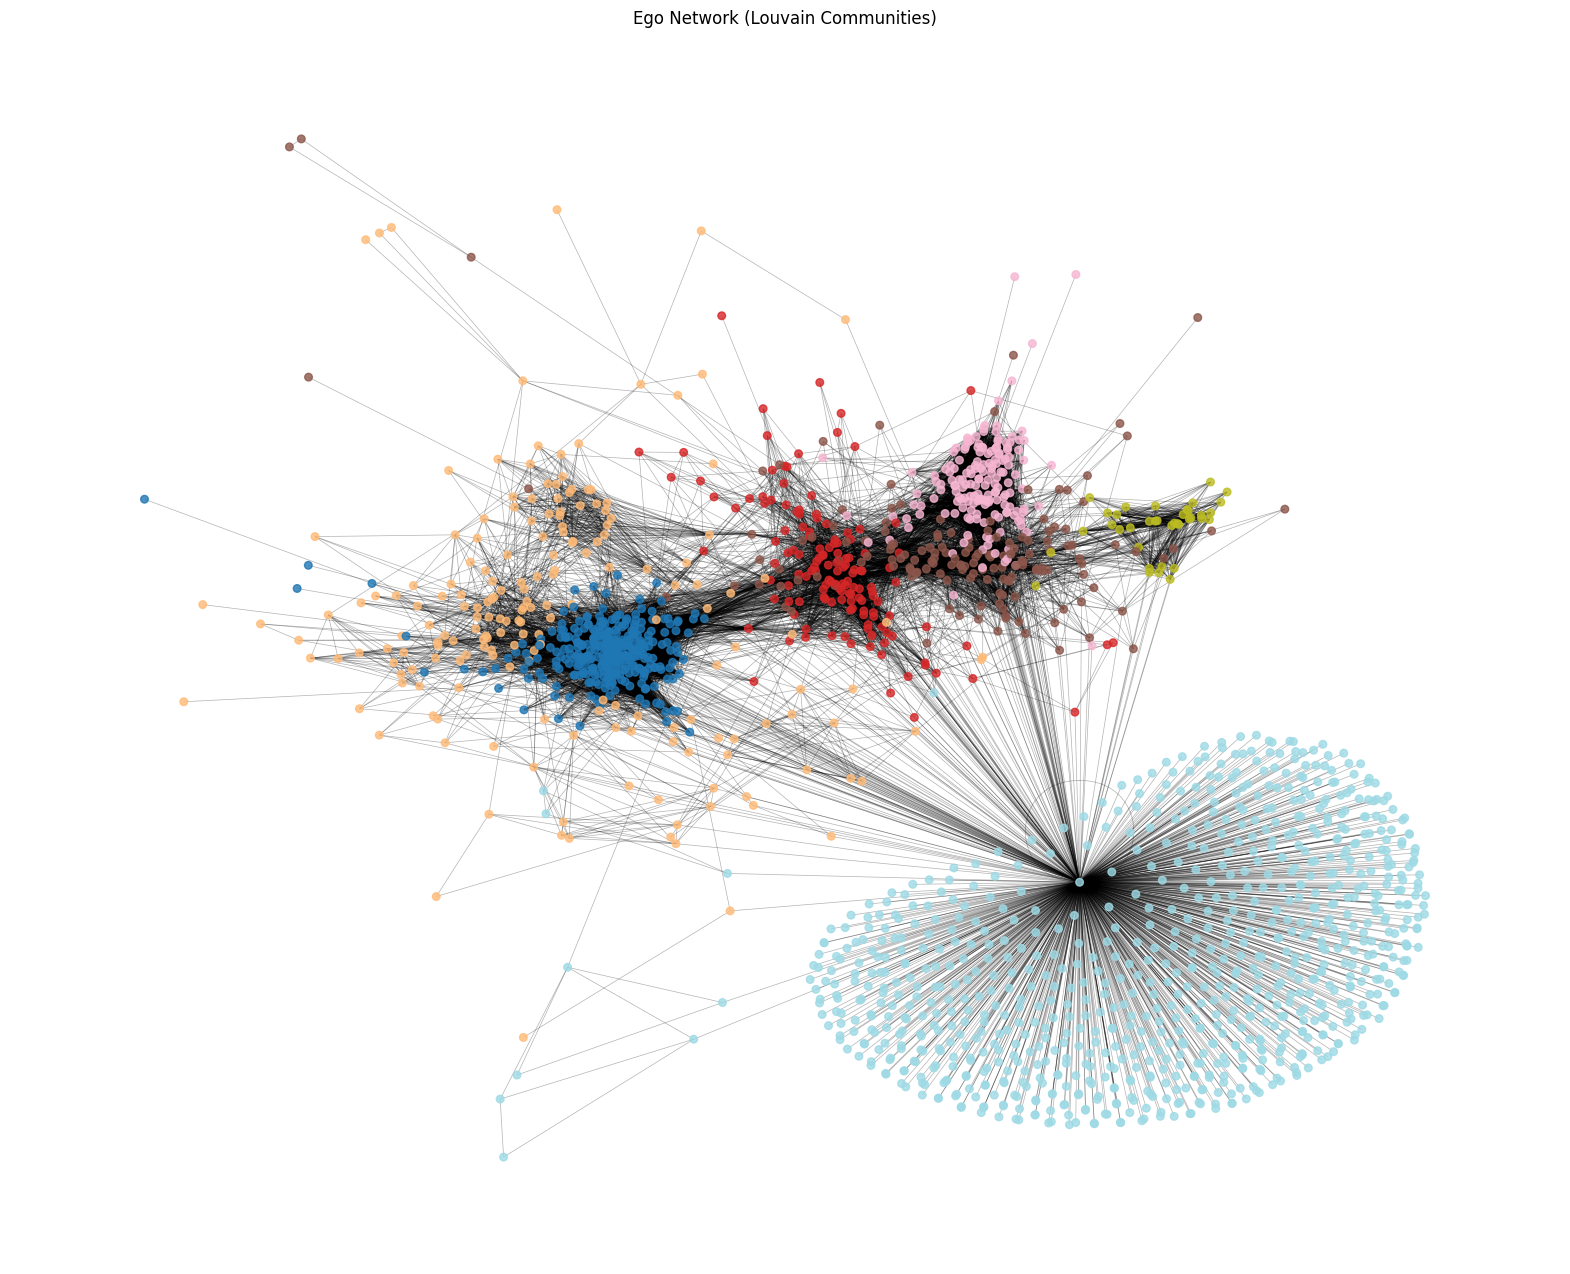

In [33]:
def draw_ego_louvain(G, ego_node_id, path="ego_network_community_colored.png"):
    partition = community_louvain.best_partition(G)
    pos = nx.spring_layout(G, seed=42)

    communities = set(partition.values())
    cmap = cm.get_cmap('tab20', len(communities))
    node_colors = [cmap(partition[n]) for n in G.nodes()]

    node_sizes = [300 if n == ego_node_id else 30 for n in G.nodes()]
    node_colors = ['green' if n == ego_node_id else cmap(partition[n]) for n in G.nodes()]

    plt.figure(figsize=(20, 16))
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)
    plt.title(f"Ego Network (Louvain Communities)")
    plt.axis('off')
    plt.show()
    plt.close()

draw_ego_louvain(G, "107")

SPECTRAL CLUSTERING

In [34]:
from sklearn.cluster import SpectralClustering
import numpy as np
import networkx as nx

# Convert NetworkX graph to adjacency matrix
adj_matrix = nx.to_numpy_array(G)

# Set number of clusters
k = 5

# Run Spectral Clustering
print(f"\n--- Spectral Clustering with {k} clusters ---")
spectral = SpectralClustering(n_clusters=k, affinity='precomputed', assign_labels='kmeans', random_state=42)
labels = spectral.fit_predict(adj_matrix)

# Map node to cluster
node_list = list(G.nodes())
node_cluster_map = dict(zip(node_list, labels))

# Group nodes by cluster
clusters = [[] for _ in range(k)]
for node, cluster_id in node_cluster_map.items():
    clusters[cluster_id].append(node)

# Find the largest cluster
largest_cluster_nodes = max(clusters, key=len)
print(f"\nLargest cluster size: {len(largest_cluster_nodes)}")

# Analyze the largest cluster
subG = G.subgraph(largest_cluster_nodes)
density = nx.density(subG)
clustering = nx.average_clustering(subG)

print(f"- Density: {density:.3f}")
print(f"- Average Clustering: {clustering:.3f}")

# Top degree nodes
top_nodes = sorted(subG.degree(), key=lambda x: x[1], reverse=True)[:3]
top_node_str = ', '.join(str(n) for n, _ in top_nodes)
print(f"- Top nodes: {top_node_str}")

# Feature aggregation (same logic as Louvain)
print("\n--- Analyzing Most Common Features in Largest Spectral Cluster ---")

vectors = []
expected_len = len(featnames)

for node in largest_cluster_nodes:
    feats = G.nodes[node].get("features")
    if feats:
        if len(feats) < expected_len:
            feats = feats + [0] * (expected_len - len(feats))
        elif len(feats) > expected_len:
            feats = feats[:expected_len]
        vectors.append(feats)

if not vectors:
    print("No feature data found.")
else:
    feature_matrix = np.array(vectors)
    binary_matrix = (feature_matrix != 0).astype(int)
    feature_counts = binary_matrix.sum(axis=0)

    sorted_features = sorted(enumerate(feature_counts), key=lambda x: x[1], reverse=True)

    print("Top 10 features in the largest spectral cluster:")
    count = 0
    for idx, freq in sorted_features:
        if idx >= len(featnames):
            continue
        fname = featnames[idx]
        if "birthday" not in fname.lower():  # Optional exclusion
            print(f"{idx}: {fname} (count: {int(freq)})")
            count += 1
        if count == 10:
            break



--- Spectral Clustering with 5 clusters ---

Largest cluster size: 891
- Density: 0.002
- Average Clustering: 0.016
- Top nodes: 107, 956, 979

--- Analyzing Most Common Features in Largest Spectral Cluster ---
Top 10 features in the largest spectral cluster:
221: 221 education;type;anonymized feature 54 (count: 693)
223: 223 education;with;id;anonymized feature 539 (count: 619)
349: 349 locale;anonymized feature 278 (count: 610)
266: 266 hometown;id;anonymized feature 558 (count: 573)
265: 265 gender;anonymized feature 78 (count: 299)
220: 220 education;type;anonymized feature 53 (count: 291)
222: 222 education;type;anonymized feature 55 (count: 285)
350: 350 location;id;anonymized feature 128 (count: 246)
274: 274 hometown;id;anonymized feature 563 (count: 215)
240: 240 education;year;id;anonymized feature 67 (count: 151)


Constract a full Graph for all users

In [36]:
# Initialize empty graph
G = nx.Graph()

# Step 1: Read all .edges files and build unified graph
for file in os.listdir(data_folder):
    if file.endswith(".edges"):
        ego_id = file.split(".")[0]
        path = os.path.join(data_folder, file)
        edges_df = pd.read_csv(path, sep=' ', header=None, names=['src', 'dst'])

        # Add ego node and its edges
        for _, row in edges_df.iterrows():
            src = str(row['src'])
            dst = str(row['dst'])
            G.add_edge(src, dst)
            G.add_node(ego_id)         # make sure ego node exists
            G.add_edge(ego_id, src)
            G.add_edge(ego_id, dst)

print(f"Unified graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Step 2: Add features from .feat files
for file in os.listdir(data_folder):
    if file.endswith(".feat"):
        path = os.path.join(data_folder, file)
        features_df = pd.read_csv(path, sep=' ', header=None)
        for _, row in features_df.iterrows():
            node_id = str(row[0])
            features = row.values[1:].tolist()
            if node_id not in G:
                G.add_node(node_id)  # add missing node to graph
            G.nodes[node_id]["features"] = features

# Step 3: Add ego-node features from .egofeat files
for file in os.listdir(data_folder):
    if file.endswith(".egofeat"):
        ego_id = file.split(".")[0]
        path = os.path.join(data_folder, file)
        ego_features = pd.read_csv(path, sep=' ', header=None).values[0].tolist()
        if ego_id not in G:
            G.add_node(ego_id)
        G.nodes[ego_id]["features"] = ego_features

print("All features assigned successfully.")

Unified graph built with 3963 nodes and 88156 edges.
All features assigned successfully.


Find the bridges of the full graph, plot the full graph, highlight the bridges

Bridge nodes: {'0', '3437', '3980', '594', '1684', '414', '698'}


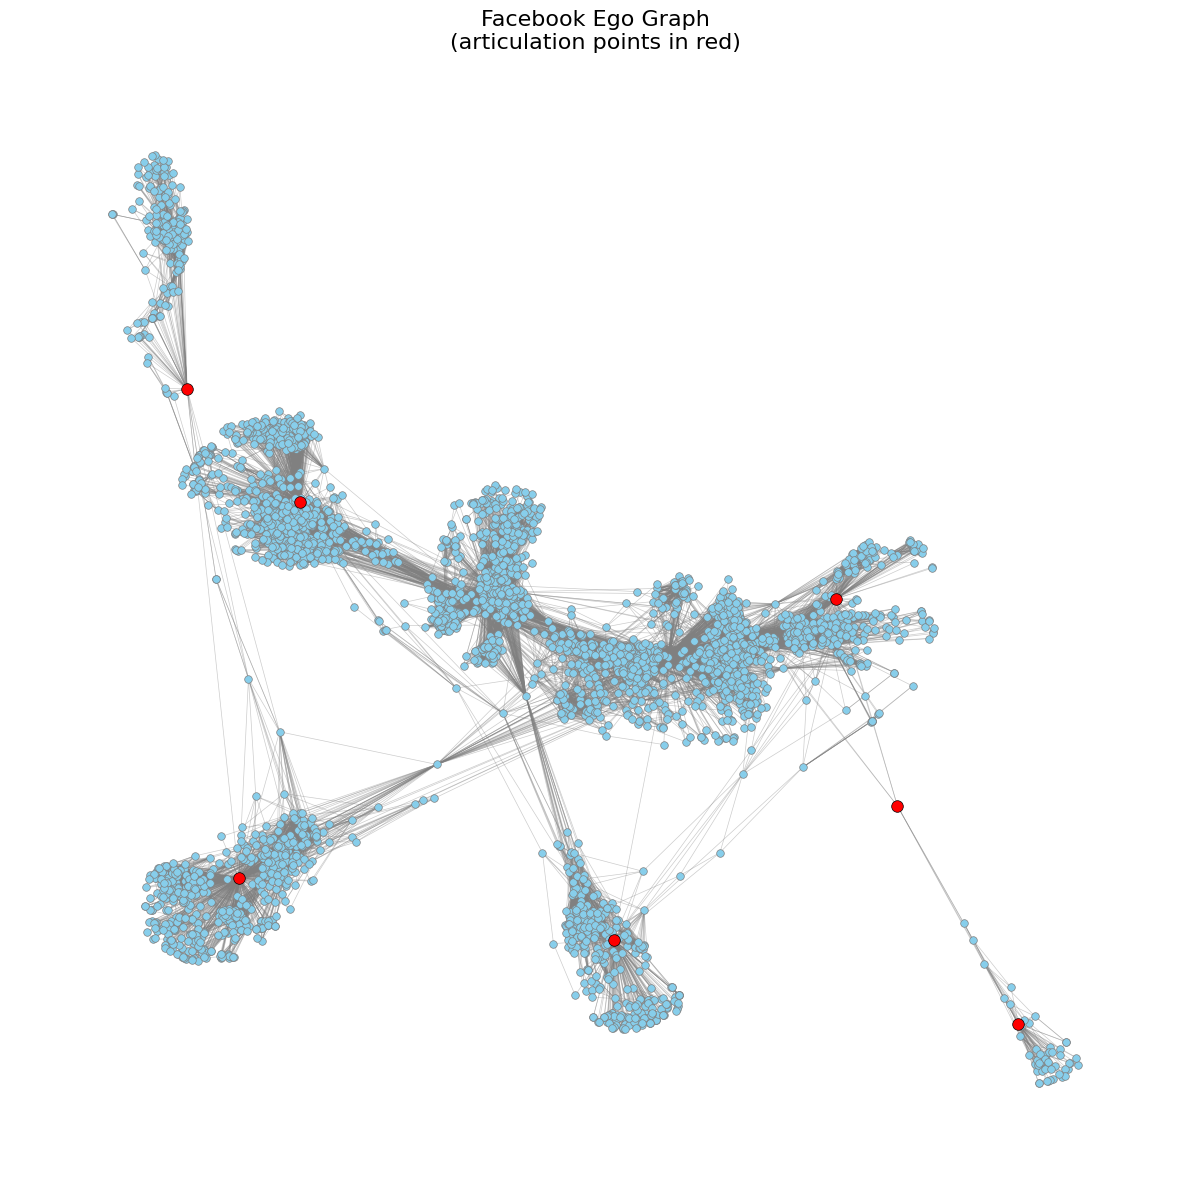

In [40]:
# remove all totally isolated nodes
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)

# now recompute layout and plot G as before...
pos = nx.spring_layout(G, seed=42)
# … draw edges, nodes, etc. …

import networkx as nx
import matplotlib.pyplot as plt

# — assume G is already built and pruned of isolates or small comps —

# 1) Compute layout once
pos = nx.spring_layout(G, seed=42)

# 2) Identify articulation‐point bridge-nodes
bridge_nodes = set(nx.articulation_points(G))
print("Bridge nodes:", bridge_nodes)

# 3) Split node lists
non_bridges = [n for n in G.nodes() if n not in bridge_nodes]
bridges     = list(bridge_nodes)

plt.figure(figsize=(12,12))

# 4a) Draw edges faintly
nx.draw_networkx_edges(
    G, pos,
    edge_color="grey",
    alpha=0.4,
    width=0.5
)

## 4b) Draw all non-bridge nodes in sky-blue, fully opaque
nx.draw_networkx_nodes(
    G, pos,
    nodelist=non_bridges,
    node_color="skyblue",
    node_size=30,
    edgecolors="grey",
    linewidths=0.5,
    alpha=1.0
)

# 4c) Draw bridge nodes last, in red, fully opaque
nx.draw_networkx_nodes(
    G, pos,
    nodelist=bridges,
    node_color="red",
    node_size=70,
    edgecolors="black",
    linewidths=0.5,
    alpha=1.0
)

plt.title("Facebook Ego Graph\n(articulation points in red)", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

